# <center>Implementation of an algebraic differential equation</center>

In [1]:
from time import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
pi = tf.constant(np.pi)

We'll implement a model to solve the system of  algebraic differential equations:

$$\begin{align*}
\frac{d^2 x}{dt^2} &= -\lambda x  \\
\frac{d^2 y}{dt^2} &= -\lambda y + g   \\
x^2 + y^2 &= L^2
\end{align*}
$$

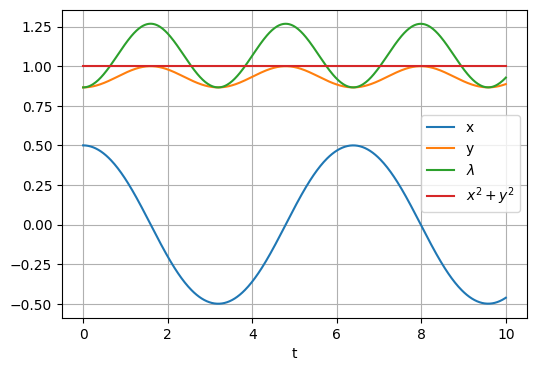

In [3]:
# Define the system of equations
L = 1  # circle radius
omega0 = 0  # initial condition for frequency
theta0 = np.pi / 6  # initial condition / initial phase
g = 1
x_0 = L*np.sin(theta0)
y_0 = L*np.cos(theta0)
lam0 = L*omega0**2 + g*np.cos(theta0)

def regular_pendulum(t,y):
  theta, dtheta = y
  return  dtheta, - g/L*np.sin(theta)

# Time span
tmax = 10
t_span = [0, tmax]
t = np.linspace(*t_span, 500)
sol_true = solve_ivp(regular_pendulum, (0, tmax), (theta0, omega0), t_eval=t,
                     dense_output=True)

def reference_solution(t):
  theta, dtheta = sol_true.sol(np.array(t).squeeze())
  # lagr_mult = - L * dtheta**2 + g * np.cos(theta)
  x_sol = L * np.sin(theta)
  y_sol = L * np.cos(theta)
  lam = L * dtheta**2 + g * np.cos(theta)
  return np.stack([x_sol, y_sol, lam], axis=-1)

x_sol, y_sol, lam = reference_solution(t).T

# Plot the solution
plt.figure(figsize=(6, 4))
plt.plot(t, x_sol, label='x')
plt.plot(t, y_sol, label='y')
plt.plot(t, lam,  label=r'$\lambda$')
plt.plot(t, x_sol**2 + y_sol**2,  label=r'$x^2+y^2$')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

The initial time

In [4]:
t_initial = tf.constant([[0.]])

A function that computes the squared residual of the differential equation at a single point given the derivatives.

In [5]:
def eq_residual(u, x_tt, y_tt):
    x = u[:,0:1]
    y = u[:,1:2]
    lmbda = u[:,2:3]
    return  (x_tt + lmbda*x)**2 + (y_tt + lmbda*y - g)**2

We define a model that forces the relation $$x^2 + y^2=L$$
exactly. To do that we can define our model as $$F_\theta(t)=\left(L\sin(f_\theta(t)), L\cos(f_\theta(t)), \lambda_\theta(t)\right).$$
The following code defines $f_\theta$ and $\lambda_\theta$ as neural networks of depths, respectively, `depth[0]` and `depth[1]`.

In [6]:
def build_model(units=40, depth=[3, 3]):
    input = keras.layers.Input(shape=(1, ))
    output = keras.layers.Dense(units=units, activation="tanh", kernel_initializer='glorot_normal')(input)

    for _ in range(depth[0]-1):
        output = keras.layers.Dense(units, activation="tanh", kernel_initializer='glorot_normal')(output)

    theta = keras.layers.Dense(1, activation="tanh", kernel_initializer='glorot_normal')(output)
    x = keras.layers.Lambda(lambda x: L*tf.math.sin(x))(theta)
    y = keras.layers.Lambda(lambda x: L*tf.math.cos(x))(theta)
    z = keras.layers.Dense(units=units, activation="tanh", kernel_initializer='glorot_normal')(input)

    for _ in range(depth[1]-1):
        z = keras.layers.Dense(units=units, activation="tanh", kernel_initializer='glorot_normal')(z)
    z = keras.layers.Dense(1)(z)

    output = keras.layers.concatenate([x, y, z])
    model = keras.models.Model(input, output)

    return model

The following function computes the derivatives that will be fed to the function `eq_residual`.

In [7]:
def get_derivatives(model, t):
    with tf.GradientTape(persistent=True) as tape:
        '''a function that returns the derivatives
        x_tt, y_tt and x_t(t_0) and y_t(t_0)'''

        tape.watch(t)
        u = model(t)
        x, y = u[:,0:1], u[:,1:2]
        x_t = tape.gradient(x, t)
        y_t = tape.gradient(y, t)

        tape.watch(t_initial)
        x0 = model(t_initial)[:,0:1]
        y0 = model(t_initial)[:,1:2]

        xt_0 = tape.gradient(x0, t_initial)
        yt_0 = tape.gradient(y0, t_initial)

    x_tt = tape.gradient(x_t, t)
    y_tt = tape.gradient(y_t, t)
    del tape

    return u, xt_0, yt_0, x_tt, y_tt

The total loss is the sum of the residual error and the initial condition error.

In [8]:
def loss_fn(model, t):
    u, xt_0, yt_0, x_tt, y_tt = get_derivatives(model, t)

    res = eq_residual(u, x_tt, y_tt)
    loss_res = tf.reduce_mean(res)

    u0_pred = model(t_initial)
    loss_ic1 =  (u0_pred[:,0:1] - x_0)**2 + (u0_pred[:,1:2] - y_0)**2
    loss_ic2 =  (xt_0)**2 + (yt_0)**2

    return loss_ic1 + loss_ic2 + loss_res

The following function computes the gradient of the total (obtained from `loss_fn`) with respect to the parameters  (weights+biases) of the model. These are stored in `model.trainable_variables`.

In [9]:
def loss_grad(model, t):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = loss_fn(model, t)

    grad_theta = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, grad_theta

Initialization of the model and set the hyperparameters as the optimizer and the learning rate.

In [10]:
model = build_model()
t_train = tf.random.uniform((1000, 1), 0, 10)

In [11]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [12]:
@tf.function
def train_step(model, t):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = loss_grad(model, t)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
N = 20000
hist = []

for i in range(N):
    # t_train = tf.random.uniform((512, 1), 0, 10)
    loss = train_step(model, t_train)

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%1000 == 0:
        print('It {}: loss = {}'.format(i,loss.numpy()))

It 0: loss = [[0.8395361]]
It 1000: loss = [[0.00649852]]
It 2000: loss = [[0.00593453]]
It 3000: loss = [[0.00545676]]
It 4000: loss = [[0.00413037]]
It 5000: loss = [[0.00307975]]
It 6000: loss = [[0.002041]]
It 7000: loss = [[0.0011056]]
It 8000: loss = [[0.00082774]]
It 9000: loss = [[0.00177438]]
It 10000: loss = [[0.00062841]]
It 11000: loss = [[0.00047836]]
It 12000: loss = [[0.00025215]]
It 13000: loss = [[0.0001265]]
It 14000: loss = [[5.2195355e-05]]
It 15000: loss = [[0.00043308]]
It 16000: loss = [[0.00024961]]
It 17000: loss = [[1.0101667e-05]]
It 18000: loss = [[8.627658e-06]]
It 19000: loss = [[0.00014083]]


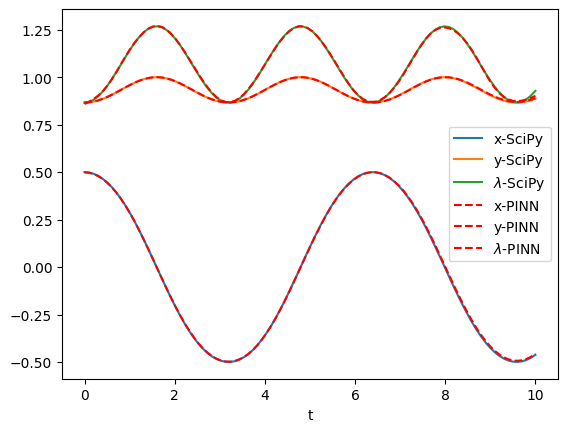

In [13]:
t = np.linspace(0, 10, 100)
x_sol, y_sol, lam = reference_solution(t).T
plt.plot(t, x_sol, label='x-SciPy')
plt.plot(t, y_sol, label='y-SciPy')
plt.plot(t, lam,  label=r'$\lambda$-SciPy')

plt.plot(t, model(t)[:,0:1], "r--",label='x-PINN')
plt.plot(t, model(t)[:,1:2], "r--",label='y-PINN')
plt.plot(t, model(t)[:,2:], "r--",label=r'$\lambda$-PINN')
plt.xlabel("t")
plt.legend(loc="best")
plt.show()